In [21]:
!python -m pip install -U pip
!python -m pip install tqdm torch torchvision medmnist matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# To access example workspaces and director/envoy scripts
!rm -rf openfl
!git clone -b miccai_fl_tutorial https://github.com/intel/openfl.git
!cd openfl && python -m pip install .

Cloning into 'openfl'...
remote: Enumerating objects: 7205, done.
remote: Counting objects: 100% (364/364), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 7205 (delta 177), reused 236 (delta 110), pack-reused 6841
Receiving objects: 100% (7205/7205), 122.61 MiB | 22.68 MiB/s, done.
Resolving deltas: 100% (4268/4268), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/openfl/openfl-tutorials/interactive_api/PyTorch_MedMNIST_2D/openfl
  Preparing metadata (setup.py) ... done
  Created wheel for openfl: filename=openfl-1.4-py3-none-any.whl size=619342 sha256=ae73426d8b16f7fb2beef75ffd4724706a4eb890b6baba6e9533bcca88540420
  Stored in directory: /tmp/pip-ephem-wheel-cache-4vqgmqso/wheels/89/06/8f/1e40e0f27686f785ab0663e5e93a0e1d47a41fc39853badfb9
Successfully built openfl
  Attempting uninstall: openfl
    Found existing installation: openfl 1.4
    Uninstalling openfl-1.4:
      Successfully 

In [23]:
import os
import logging

# Better CPU Utilization
os.environ['OMP_NUM_THREADS'] = str(int(os.cpu_count()))

# Logging fix for Google Colab
log = logging.getLogger()
log.setLevel(logging.INFO)

# Switch to the tutorial directory within OpenFL tutorials
tutorial_dir = os.path.abspath(
    'openfl/openfl-tutorials/interactive_api/PyTorch_MedMNIST_2D')
os.chdir(tutorial_dir)

Part 1. Centralized Setting

In [24]:
import numpy as np
from tqdm import tqdm
from pprint import pprint

import torch
import medmnist

print('PyTorch', torch.__version__)
print('MedMNIST', medmnist.__version__)

PyTorch 1.13.1+cu116
MedMNIST 2.1.0


Dataset Configuration

In [25]:
# Train/test options
NUM_EPOCHS = 3
BATCH_SIZE = 64
DEVICE = 'cpu'

# Dataset
DATASET_NAME = 'bloodmnist'
DATASET_PATH = './data'
ds_info = medmnist.INFO[DATASET_NAME]
pprint(ds_info)

{'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'description': 'The BloodMNIST is based on a dataset of individual normal '
                'cells, captured from individuals without infection, '
                'hematologic or oncologic disease and free of any '
                'pharmacologic treatment at the moment of blood collection. It '
                'contains a total of 17,092 images and is organized into 8 '
                'classes. We split the source dataset with a ratio of 7:1:2 '
                'into training, validation and test set. The source images '
                'with resolution 3×360×363 pixels are center-cropped into '
                '3×200×200, and then resized into 3×28×28.',
 'label': {'0': 'basophil',
           '1': 'eosinophil',
           '2': 'erythroblast',
           '3': 'immature granulocytes(myelocytes, metamyelocytes and '
                'promyelocytes)',
           '4': 'lymphocyte',
           '5': 'monocyte',
           '6': 'neutrophil',
      

Data visulaisation

INFO:envoy.medmnist_shard_descriptor:Dataset bloodmnist.npz not found at:./data.
	Downloading...
INFO:envoy.medmnist_shard_descriptor:./data
bloodmnist.npz
{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'task': 'multi-class', 'label': {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyt

  0%|          | 0/35461855 [00:00<?, ?it/s]

INFO:envoy.medmnist_shard_descriptor:DONE!
INFO:envoy.medmnist_shard_descriptor:MedMNIST data was loaded!
INFO:envoy.medmnist_shard_descriptor:MedMNIST data was loaded!


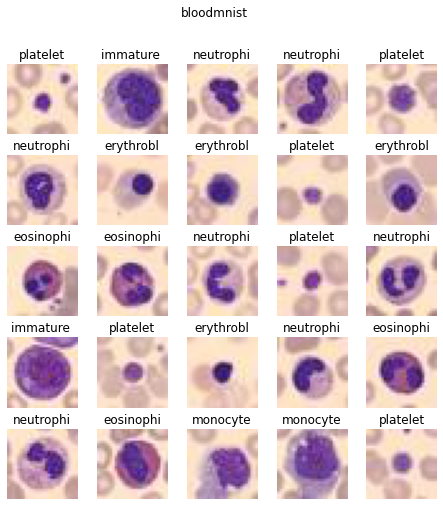

In [26]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

from envoy.medmnist_shard_descriptor import MedMNISTShardDescriptor

# Download raw numpy dataset
sd = MedMNISTShardDescriptor(datapath=DATASET_PATH, dataname=DATASET_NAME)
(x_train, y_train), (x_test, y_test) = sd.load_data()

# Visualize few samples
n_img = 5
train_samples = x_train[:n_img*n_img]

label2str = list(ds_info['label'].values())

fig, ax = plt.subplots(n_img, n_img, figsize=(8, 8))

for k in range(len(train_samples)):
    i = k // n_img
    j = k % n_img
    img = train_samples[k]
    label = np.squeeze(y_train[k])
    ax[i, j].imshow(Image.fromarray(img))
    ax[i, j].title.set_text(label2str[label][:9])
    ax[i, j].axis('off')
plt.suptitle(DATASET_NAME)
fig.subplots_adjust(wspace=0.03, hspace=0.3)

Define Dataset/Dataloader Classes

In [27]:
class MedMNISTDataset(Dataset):
    """MedMNIST dataset class"""

    def __init__(self, x, y, data_type: str = 'train') -> None:
        """Initialize MedMNISTDataset."""
        self.x, self.y = x, y
        self.data_type = data_type

    def __getitem__(self, index: int):
        """Return an item by the index."""
        return self.x[index], self.y[index]

    def __len__(self) -> int:
        """Return the len of the dataset."""
        return len(self.x)


class TransformDataset(Dataset):
    """Apply transforms to each element of dataset"""

    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]

        if self.target_transform:
            label = self.target_transform(label)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        
        return img, label


transform = T.Compose([T.ToTensor(), T.Normalize(mean=[0.], std=[1.0])])

train_ds = TransformDataset(MedMNISTDataset(x=x_train, y=y_train),
                              transform=transform)
train_dl = DataLoader(train_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=8)

test_ds = TransformDataset(MedMNISTDataset(x=x_test, y=y_test),
                             transform=transform)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=8)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Model Definition (CNN)

In [28]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(16, 16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(16, 64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 128), 
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


test_model = Net(in_channels=ds_info['n_channels'],
                 num_classes=len(ds_info['label']))
print(test_model)
print('Total Parameters:',
      sum([torch.numel(p) for p in test_model.parameters()]))
print('Trainable Parameters:',
      sum([torch.numel(p) for p in test_model.parameters() if p.requires_grad]))

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

Define Training/Validation Loops

In [29]:
def train(model, train_loader, optimizer, device, criterion, task):
    model.train()
    model = model.to(device)

    losses = []
    correct = 0
    total = 0
    for inputs, targets in tqdm(train_loader, desc="train"):

        optimizer.zero_grad()
        outputs = model(inputs.to(device))

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
        else:
            targets = torch.squeeze(targets, 1).long().to(device)
            loss = criterion(outputs, targets)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    total += targets.shape[0]
    correct += torch.sum(outputs.max(1)[1] == targets).item()

    return {
        'train_acc': np.round(correct / total, 3),
        'train_loss': np.round(np.mean(losses), 3),
    }


def validate(model, val_loader, device, criterion, task):
    model.eval()
    model = model.to(device)

    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="validate"):
            outputs = model(inputs.to(device))

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                m = nn.Sigmoid()
                outputs = m(outputs).to(device)
            else:
                targets = torch.squeeze(targets, 1).long().to(device)
                loss = criterion(outputs, targets)

            losses.append(loss.item())
            total += targets.shape[0]
            correct += (outputs.max(1)[1] == targets).sum().cpu().numpy()

        return {
            'val_acc': np.round(correct / total, 3),
            'val_loss': np.round(np.mean(losses), 3),
        }


Train

In [30]:
centralized_model = Net(in_channels=ds_info['n_channels'],
                        num_classes=len(ds_info['label']))
optimizer = torch.optim.Adam(centralized_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Start!
history = validate(centralized_model,test_dl,device=DEVICE,criterion=criterion,task=ds_info['task'])
print('Before training: ', history)

for epoch in range(NUM_EPOCHS):
    train_history = train(centralized_model,
                          train_dl,
                          device=DEVICE,
                          optimizer=optimizer,
                          criterion=criterion,
                          task=ds_info['task'])
    val_history = validate(centralized_model,
                           test_dl,
                           device=DEVICE,
                           criterion=criterion,
                           task=ds_info['task'])
    print(f'Epoch {epoch}: {train_history} - {val_history}')


validate: 100%|██████████| 54/54 [00:05<00:00, 10.69it/s]


Before training:  {'val_acc': 0.072, 'val_loss': 2.078}


validate: 100%|██████████| 54/54 [00:02<00:00, 19.97it/s]


Epoch 0: {'train_acc': 0.855, 'train_loss': 1.037} - {'val_acc': 0.791, 'val_loss': 0.57}


validate: 100%|██████████| 54/54 [00:02<00:00, 20.97it/s]


Epoch 1: {'train_acc': 0.764, 'train_loss': 0.549} - {'val_acc': 0.853, 'val_loss': 0.416}


validate: 100%|██████████| 54/54 [00:02<00:00, 20.70it/s]

Epoch 2: {'train_acc': 0.873, 'train_loss': 0.435} - {'val_acc': 0.859, 'val_loss': 0.369}


Federated

In [31]:
import os
import yaml
import time
from pathlib import Path
from typing import Dict, List, Union

Configure Director

In [32]:
# Should be the same as defined in `director_config.yaml`
director_node_fqdn = 'localhost'
director_port = 50051

director_workspace_path = os.path.join(tutorial_dir, 'director')
director_config_file = os.path.join(director_workspace_path,'director_config.yaml')
director_logfile = os.path.join(director_workspace_path, 'director.log')

# Start director
os.system(f'cd {director_workspace_path};'
          f'fx director start --disable-tls -c {director_config_file} '
          f'>{director_logfile} &')
!sleep 5 && tail -n5 $director_logfile

Configure Envoys

In [33]:
def generate_envoy_configs(
        config: dict,
        n_cols: int,
        datapath: str,
        dataname: str,
        save_path: str) -> list:
    
    config_paths = list()
    for i in range(1, n_cols+1):
        path = os.path.abspath(os.path.join(save_path, f'{i}_envoy_config.yaml'))
        config['shard_descriptor']['params']['datapath'] = datapath
        config['shard_descriptor']['params']['dataname'] = dataname    
        config['shard_descriptor']['params']['rank_worldsize'] = f'{i},{n_cols}'
        with open(path, 'w') as f:
            yaml.safe_dump(config, f)
        config_paths.append(path)
    return config_paths

Generate configs and start Envoys

In [34]:
# Read the original envoy config file content
original_config_path = os.path.join(tutorial_dir, 'envoy', 'envoy_config.yaml')
with open(original_config_path, 'r') as f:
    original_config = yaml.safe_load(f)

# Generate configs for as many envoys
config_paths = generate_envoy_configs(original_config,
                                      n_cols=2,
                                      datapath=DATASET_PATH,
                                      dataname=DATASET_NAME,
                                      save_path=os.path.dirname(original_config_path))
# Start envoys in a loop
cwd = os.getcwd()
for i, path in enumerate(config_paths):
    print(f'Starting Envoy {i+1}')
    os.chdir(os.path.dirname(path))

    # Wait until envoy loads dataset
    os.system(f'fx envoy start -n env_{i+1} --disable-tls '
                f'--envoy-config-path {path} -dh {director_node_fqdn} -dp {director_port} '
                f'>env_{i+1}.log 2>&1 &')
    !grep -q "MedMNIST data was loaded" <( tail -f env_{i+1}.log )
    
    os.chdir(cwd)

Starting Envoy 1
Starting Envoy 2


Connect this Notebook

In [35]:
# Create a federation
from openfl.interface.interactive_api.federation import Federation

# Federation can also determine local fqdn automatically
federation = Federation(client_id='frontend',
                        director_node_fqdn=director_node_fqdn,
                        director_port=director_port,
                        tls=False)

# Data scientist may request a list of connected envoys
shard_registry = federation.get_shard_registry()
pprint(shard_registry)

{'env_1': {'current_time': '2023-01-18 15:12:02',
           'experiment_name': 'ExperimentName Mock',
           'is_experiment_running': False,
           'is_online': True,
           'last_updated': '2023-01-18 15:11:53',
           'shard_info': node_info {
  name: "env_1"
}
shard_description: "MedMNIST dataset, shard number 1 out of 2"
sample_shape: "28"
sample_shape: "28"
sample_shape: "3"
target_shape: "1"
target_shape: "1"
,
           'valid_duration': seconds: 120
},
 'env_2': {'current_time': '2023-01-18 15:12:02',
           'experiment_name': 'ExperimentName Mock',
           'is_experiment_running': False,
           'is_online': True,
           'last_updated': '2023-01-18 15:12:00',
           'shard_info': node_info {
  name: "env_2"
}
shard_description: "MedMNIST dataset, shard number 2 out of 2"
sample_shape: "28"
sample_shape: "28"
sample_shape: "3"
target_shape: "1"
target_shape: "1"
,
           'valid_duration': seconds: 120
}}


DataInterface 

In [43]:
# Create a federation
from openfl.interface.interactive_api.federation import Federation

# Federation can also determine local fqdn automatically
federation = Federation(client_id='frontend',
                        director_node_fqdn=director_node_fqdn,
                        director_port=director_port,
                        tls=False)

# Data scientist may request a list of connected envoys
shard_registry = federation.get_shard_registry()
pprint(shard_registry)


{'env_1': {'current_time': '2023-01-18 15:34:20',
           'experiment_name': 'ExperimentName Mock',
           'is_experiment_running': False,
           'is_online': True,
           'last_updated': '2023-01-18 15:34:06',
           'shard_info': node_info {
  name: "env_1"
}
shard_description: "MedMNIST dataset, shard number 1 out of 2"
sample_shape: "28"
sample_shape: "28"
sample_shape: "3"
target_shape: "1"
target_shape: "1"
,
           'valid_duration': seconds: 120
},
 'env_2': {'current_time': '2023-01-18 15:34:20',
           'experiment_name': 'ExperimentName Mock',
           'is_experiment_running': False,
           'is_online': True,
           'last_updated': '2023-01-18 15:34:14',
           'shard_info': node_info {
  name: "env_2"
}
shard_description: "MedMNIST dataset, shard number 2 out of 2"
sample_shape: "28"
sample_shape: "28"
sample_shape: "3"
target_shape: "1"
target_shape: "1"
,
           'valid_duration': seconds: 120
}}


ModelInterface

In [38]:
from openfl.interface.interactive_api.experiment import ModelInterface

model = Net(in_channels=ds_info['n_channels'],
            num_classes=len(ds_info['label']))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
framework_adapter = 'openfl.plugins.frameworks_adapters.pytorch_adapter.FrameworkAdapterPlugin'

MI = ModelInterface(model=model,
                    optimizer=optimizer,
                    framework_plugin=framework_adapter)

Taskinterface

In [39]:
from openfl.interface.interactive_api.experiment import TaskInterface

# Task interface currently supports only standalone functions.
TI = TaskInterface()
fixed = {'criterion': criterion, 'task': ds_info['task']}

# Train task
TI.add_kwargs(**fixed)(TI.register_fl_task(model='model',
                                           data_loader='train_loader',
                                           device='device',
                                           optimizer='optimizer')(train))

# Validate task
TI.add_kwargs(**fixed)(TI.register_fl_task(model='model',
                                           device='device',
                                           data_loader='val_loader')(validate))

<function __main__.validate(model, val_loader, device, criterion, task)>

Run the experiment

In [ ]:
from openfl.interface.interactive_api.experiment import FLExperiment

fl_experiment = FLExperiment(federation=federation,
                             experiment_name='bloodmnist2d_experiment')
fl_experiment.start(model_provider=MI,
                    task_keeper=TI,
                    data_loader=fed_dataset,
                    rounds_to_train=3,
                    device_assignment_policy='CUDA_PREFERRED')

In [ ]:
# This method not only prints messages recieved from the director,
# but also saves logs in the tensorboard format (by default)
fl_experiment.stream_metrics()